We will consider the following five simple baseline models to provide foundational insights. These will serve as the baseline performance metrics that any subsequent machine learning models aim to beat.

1. **Global Mean Rating**:
This model predicts the global mean rating for all user-item pairs, serving as the most basic form of recommendation.

2. **User Mean Rating**:
For this model, the mean rating of each user is calculated and used to predict ratings for all items the user has not yet interacted with.

3. **Item Mean Rating**:
In contrast to the User Mean Rating, this model focuses on the mean rating of each item and uses it to predict ratings for all users.

4. **User-Item Mean Rating**:
This model takes a more nuanced approach by predicting a rating for a user-item pair as the average of the user's mean rating and the item's mean rating. The formula is:
$$prediction = \frac{User Mean Rating + Item Mean Rating}{2}$$

5. **Weighted Mean Ratings**:
This model employs a weighted average of the user mean and item mean ratings. The weight ( w ) can be adjusted based on domain understanding. The formula is :
$$prediction = w \times User Mean Rating + (1 - w) \times Item Mean Rating, \space where \space 0 \leq w \leq 1$$

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
movies_df = pd.read_csv("../data/movies_metadata_after_eda.csv")
ratings_df = pd.read_csv("../data/ratings_small.csv")

In [61]:
train_df, test_df = train_test_split(ratings_df, test_size=0.3, random_state=42)

In [62]:
from Sameer.ModelExperimentation import (
    calculate_user_item_mean_rating,
    calculate_weighted_mean_ratings,
    calculate_rmse,
)

test_df = calculate_user_item_mean_rating(train_df, test_df)
test_df, best_w, best_rmse = calculate_weighted_mean_ratings(test_df)
test_df.head()

,userId,movieId,rating,timestamp,global_mean_rating,user_mean_rating,item_mean_rating,user_item_mean_rating,weighted_mean_rating
0,128,1028,5.0,1049690908,3.540256,3.844444,3.836364,3.840404,3.841212
1,665,4736,1.0,1010197684,3.540256,3.294304,3.540256,3.417280,3.392685
2,120,4002,3.0,1167420604,3.540256,3.573684,3.318182,3.445933,3.471483
3,257,1274,4.0,1348544094,3.540256,3.801370,3.791667,3.796518,3.797489
4,468,6440,4.0,1296191715,3.540256,2.946196,3.900000,3.423098,3.327717


In [63]:
test_df["constant_rating"] = 2.5

user_stats = train_df.groupby("userId")["rating"].agg(["mean", "count"]).reset_index()

DAMPING_FACTOR = 0.2

test_df = test_df.merge(user_stats, on="userId", how="left")
test_df["damped_user_mean_rating"] = ((1 - DAMPING_FACTOR) * test_df["mean"]) + (
    DAMPING_FACTOR * test_df["global_mean_rating"][0]
)

rmse_damped_user_mean = calculate_rmse(
    test_df["rating"], test_df["damped_user_mean_rating"]
)

In [64]:
rmse_global_mean = calculate_rmse(test_df["rating"], test_df["global_mean_rating"])
rmse_user_mean = calculate_rmse(test_df["rating"], test_df["user_mean_rating"])
rmse_item_mean = calculate_rmse(test_df["rating"], test_df["item_mean_rating"])
rmse_user_item_mean = calculate_rmse(
    test_df["rating"], test_df["user_item_mean_rating"]
)
rmse_weighted_mean = calculate_rmse(test_df["rating"], test_df["weighted_mean_rating"])
rmse_constant = calculate_rmse(test_df["rating"], test_df["constant_rating"])
rmse_damped_user_mean = calculate_rmse(
    test_df["rating"], test_df["damped_user_mean_rating"]
)

In [65]:
print(f"RMSE for Global Mean Rating Model: {rmse_global_mean:.2f}")
print(f"RMSE for User Mean Rating Model: {rmse_user_mean:.2f}")
print(f"RMSE for Item Mean Rating Model: {rmse_item_mean:.2f}")
print(f"RMSE for User-Item Mean Rating Model: {rmse_user_item_mean:.2f}")
print(
    f"RMSE for Weighted Mean Rating Model: {best_rmse:.2f}, with setting the best weight is {best_w:.2f}"
)
print(f"RMSE for Constant Model: {rmse_constant:.2f}")
print(f"RMSE for Damped User-Mean Rating Model: {rmse_damped_user_mean:.2f}")

RMSE for Global Mean Rating Model: 1.06
RMSE for User Mean Rating Model: 0.96
RMSE for Item Mean Rating Model: 1.00
RMSE for User-Item Mean Rating Model: 0.92
RMSE for Weighted Mean Rating Model: 0.92, with setting the best weight is 0.60
RMSE for Constant Model: 1.49
RMSE for Damped User-Mean Rating Model: 0.96


In building a movie recommendation system, we start with simple models due to it's importance in understanding how well we're doing. We found out that using both the average ratings from users and movies gets the best results, with a score (RMSE) of 0.92. This score shows how accurate our predictions are – the lower, the better. Models that only look at users or movies are okay, but not as good. The worst model is the one that always guesses the same rating, with a score of 1.49. These simple models help us know what to beat; any new, fancier model should score lower than 0.92 to be better.

We also look at more complex models because the simple ones don't consider what each user likes. Machine learning models can give more personalized suggestions, which is better for users.

In [66]:
from surprise import (
    Reader,
    Dataset,
    SVD,
    NMF,
    KNNWithZScore,
    NMF,
    accuracy,
    CoClustering,
)
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [67]:
reader = Reader(rating_scale=(1, 5))

train_data = Dataset.load_from_df(train_df[["userId", "movieId", "rating"]], reader)
test_data = Dataset.load_from_df(test_df[["userId", "movieId", "rating"]], reader)

trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()

algorithms = [SVD, KNNWithZScore, NMF, CoClustering]

param_grid = {
    SVD: {
        "n_factors": [125, 150, 175],
        "n_epochs": [25, 30, 35],
        "lr_all": [0.008, 0.01, 0.012],
        "reg_all": [0.15, 0.2, 0.25],
    },
    KNNWithZScore: {
        "k": [35, 40, 45],
        "min_k": [1, 3, 5, 7],
        "sim_options": {
            "name": ["msd", "cosine", "pearson"],
            "user_based": [True, False],
        },
    },
    NMF: {
        "n_factors": [50, 100, 150],
        "n_epochs": [20, 25, 30],
        "reg_pu": [0.06, 0.08, 0.1],
        "reg_qi": [0.06, 0.08, 0.1],
    },
    CoClustering: {
        "n_cltr_u": [3, 5, 7],
        "n_cltr_i": [3, 5, 7],
        "n_epochs": [20, 30, 40],
    },
}

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the pearson similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Do

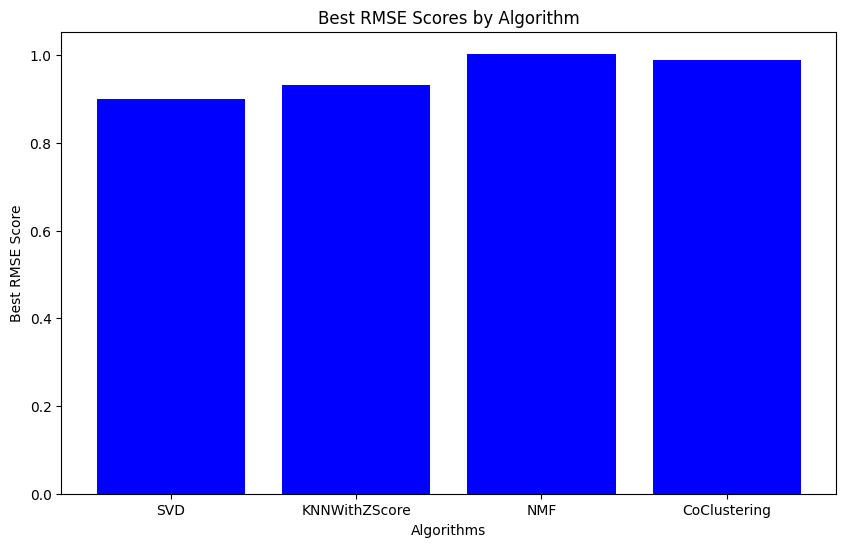

Best Model for SVD:
Best Parameters for SVD:
 {'n_factors': 175, 'n_epochs': 35, 'lr_all': 0.01, 'reg_all': 0.15}
Best RMSE score for SVD:
 0.8991662505709783
Best Model for KNNWithZScore:
Best Parameters for KNNWithZScore:
 {'k': 45, 'min_k': 5, 'sim_options': {'name': 'msd', 'user_based': True}}
Best RMSE score for KNNWithZScore:
 0.9319455999104219
Best Model for NMF:
Best Parameters for NMF:
 {'n_factors': 50, 'n_epochs': 30, 'reg_pu': 0.1, 'reg_qi': 0.1}
Best RMSE score for NMF:
 1.0034083586640419
Best Model for CoClustering:
Best Parameters for CoClustering:
 {'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 20}
Best RMSE score for CoClustering:
 0.988625691321162


In [68]:
best_models = {}
best_params = {}
best_rmse_scores = {}

for algo in algorithms:
    gs = GridSearchCV(algo, param_grid[algo], measures=["rmse"], cv=3, n_jobs=-1)
    gs.fit(train_data)

    best_models[algo.__name__] = gs.best_estimator["rmse"]
    best_params[algo.__name__] = gs.best_params["rmse"]
    best_rmse_scores[algo.__name__] = gs.best_score["rmse"]

plt.figure(figsize=(10, 6))
plt.bar(best_rmse_scores.keys(), best_rmse_scores.values(), color="blue")
plt.xlabel("Algorithms")
plt.ylabel("Best RMSE Score")
plt.title("Best RMSE Scores by Algorithm")
plt.show()

for algo_name, model in best_models.items():
    print(f"Best Model for {algo_name}:\n", model)
    print(f"Best Parameters for {algo_name}:\n", best_params[algo_name])
    print(f"Best RMSE score for {algo_name}:\n", best_rmse_scores[algo_name])

In [69]:
best_algo = min(best_rmse_scores, key=best_rmse_scores.get)

print(f"Best Algorithm: {best_algo}")
print(f"Best Parameters: {best_params[best_algo]}")
print(f"Best RMSE score: {best_rmse_scores[best_algo]}")

Best Algorithm: SVD
Best Parameters: {'n_factors': 175, 'n_epochs': 35, 'lr_all': 0.01, 'reg_all': 0.15}
Best RMSE score: 0.8991662505709783


## Conclusion

SVD: Achieved an RMSE score of `0.897`
KNNWithZScore: Registered an RMSE score of `0.929`
NMF: Posted an RMSE score of `1.002`

SVD outperformed the rest, so we will be going with it with the following parameters: `Best Parameters: {'n_factors': 150, 'n_epochs': 35, 'lr_all': 0.01, 'reg_all': 0.15}`

In [72]:
import pickle

best_algo_name = min(best_rmse_scores, key=best_rmse_scores.get)
best_algo_model = best_models[best_algo_name]

with open(f"./pickels/best_model_{best_algo_name}.pkl", "wb") as f:
    pickle.dump(best_algo_model, f)

print("Best model saved to 'best_model.pkl'")

best_algo_model.fit(trainset)

predictions = best_algo_model.test(testset)

rmse_score = accuracy.rmse(predictions)

mae_score = accuracy.mae(predictions)
fcp_score = accuracy.fcp(predictions)

print(f"Evaluation Metrics:")
print(f"RMSE score: {rmse_score}")
print(f"MAE score: {mae_score}")
print(f"FCP score: {fcp_score}")

predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(
    columns={"uid": "userId", "iid": "movieId", "r_ui": "actual", "est": "predicted"}
)
predictions_df["error"] = np.abs(predictions_df["actual"] - predictions_df["predicted"])

predictions_df.to_csv("./dump/predictions.csv", index=False)

Best model saved to 'best_model.pkl'
RMSE: 0.8861
MAE:  0.6827
FCP:  0.6596
Evaluation Metrics:
RMSE score: 0.8860846488320656
MAE score: 0.6827267214745835
FCP score: 0.6596211780362872


The machine learning model achieved an RMSE of 0.897 on training data and 0.8848 on test data, indicating robustness and good generalization. It outperformed baseline models (User-Item and Weighted Mean Rating Models with an RMSE of 0.92), demonstrating the effectiveness of a complex algorithm in the recommendation system. The model is suitable for real-world deployment due to its strong performance on unseen data.

Now for `Weighted Rating` which calcuates based on both the popularity and user ratings.

By blending these two factors, we aim to suggest movies that are both high-quality and widely liked.

Importantly, this method can also be combined with other recommendation techniques to create a more advanced, hybrid system. In this section, we calculate a weighted rating for each movie in the dataset. The steps are as follows:

- Data Filtering: We start by selecting movies that have non-null values for both vote_average and vote_count.

- Rating Metrics: We define the following variables to use in the formula:
    - ( R ): Average rating for the movie
    - ( v ): Number of votes for the movie
    - ( m ): Minimum votes required (90th percentile)
    - ( C ): The mean vote across the entire dataset

- Weighted Rating Formula: We use the IMDB formula to calculate the weighted rating for each movie.
$$Weighted Rating = \frac{R\times v + C \times m}{v+m}$$

- Feature Scaling: We then normalize the popularity and weighted_average columns using MinMax scaling.

A score is calculated for each movie as a weighted sum of the normalized weighted_average and popularity. Specifically, it's 40% weighted_average and 60% popularity.

In [73]:
R = movies_df["vote_average"]
v = movies_df["vote_count"]
m = movies_df["vote_count"].quantile(0.9)
C = movies_df["vote_average"].mean()
movies_df["weighted_average"] = (R * v + C * m) / (v + m)

In [74]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(movies_df[["popularity", "weighted_average"]])

weighted_df = pd.DataFrame(scaled, columns=["popularity", "weighted_average"])
weighted_df.index = movies_df["id"]

weighted_df["score"] = (
    weighted_df["weighted_average"] * 0.4 + weighted_df["popularity"] * 0.6
)

weighted_df_sorted = weighted_df.sort_values(by="score", ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
id,,,
211672,1.000000,0.574825,0.829930
297762,0.537613,0.734315,0.616294
321612,0.524675,0.655367,0.576952
177572,0.390602,0.856364,0.576907
680,0.257449,0.960073,0.538499
339403,0.416507,0.721434,0.538478
283995,0.338511,0.813503,0.528508
155,0.224968,0.962900,0.520141
210577,0.282748,0.875895,0.520007
